# Train and Evaluate Transfer Learning with TensorFlow

In [2]:
!pip install --upgrade tensorflow

In [3]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.12.0
Keras version: 2.12.0


### Data Modeling

In [4]:
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print(base_model.summary())

94765736/94765736 [==============================] - 159s 2us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
          

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = 'data/shapes'
pretrained_size = (224,224)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.
class names:  ['circle', 'square', 'triangle']


### Model Prdictions

In [6]:
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create prediction layer for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

### Model Training 

In [7]:
# Train the model over 3 epochs
num_epochs = 3
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/3
28/28 [==============================] - 135s 5s/step - loss: 2.3254 - accuracy: 0.5429 - val_loss: 0.3166 - val_accuracy: 0.8722
Epoch 2/3
28/28 [==============================] - 138s 5s/step - loss: 0.2159 - accuracy: 0.9464 - val_loss: 0.1906 - val_accuracy: 0.9389
Epoch 3/3
28/28 [==============================] - 127s 5s/step - loss: 0.1479 - accuracy: 0.9810 - val_loss: 0.1447 - val_accuracy: 0.9667


### Review loss History

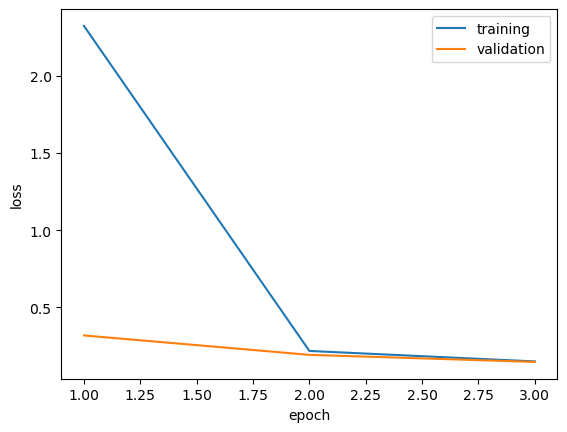

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluate Model Performance

Generating predictions from validation data...
1/1 [==============================] - 5s 5s/step


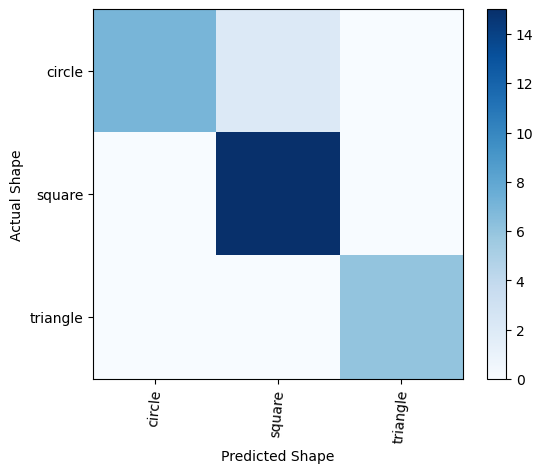

In [9]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

### Use Model Training

1/1 [==============================] - 0s 221ms/step
triangle


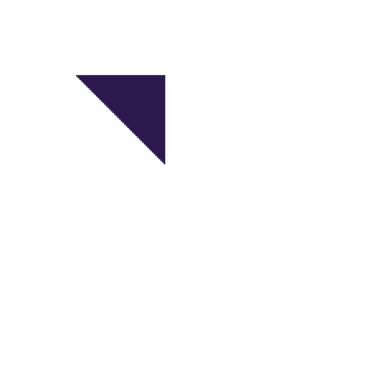

In [10]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((224,224), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
class_idx = predict_image(model, img)
print (classnames[class_idx])